<a href="https://colab.research.google.com/github/madhugoutham/Projects/blob/main/Decision_Tree_Classification_Titanic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

!pip install scikit-learn==1.3.1 xgboost==1.7.6 numpy pandas seaborn

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# =========================
# 0. IMPORT LIBRARIES
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ignore warnings for cleaner output (optional)
import warnings
warnings.filterwarnings("ignore")

# =========================
# 1. LOAD & INSPECT DATA
# =========================
df = pd.read_csv("/content/drive/My Drive/JOB projects/titanic/train.csv")  # Ensure train.csv is in the same directory
print("Data shape:", df.shape)
df.head()


Data shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


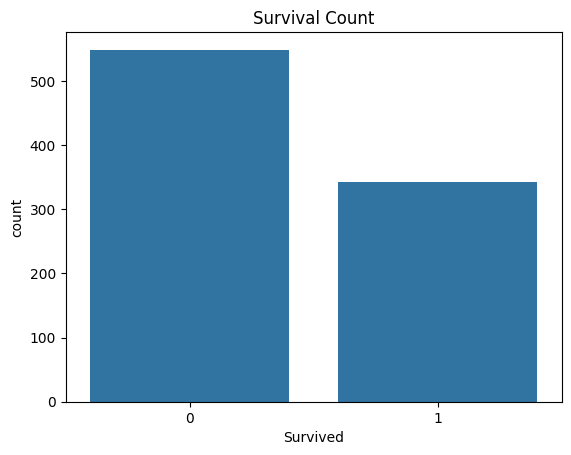

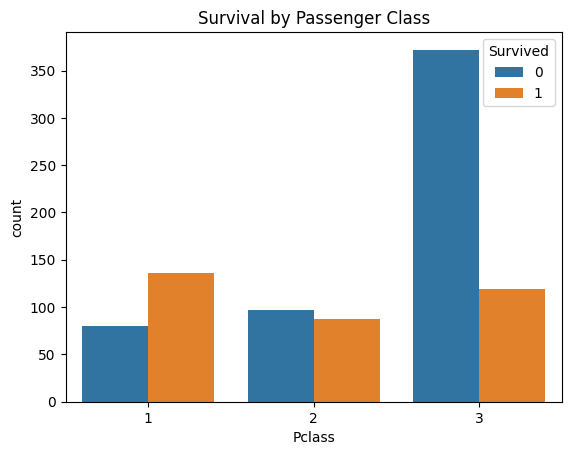

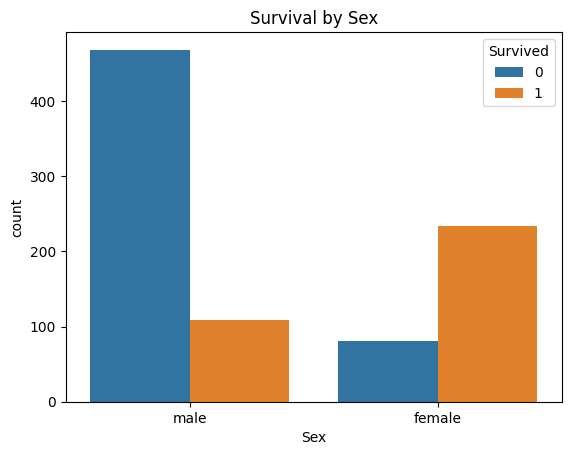

In [2]:
# =========================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# =========================

# 2.1 Basic info
df.info()

# 2.2 Check for missing values
df.isnull().sum()

# 2.3 Quick stats
df.describe(include="all")

# 2.4 Distribution of the target
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

# 2.5 Look at how some features relate to Survival
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Survival by Passenger Class")
plt.show()

sns.countplot(x='Sex', hue='Survived', data=df)
plt.title("Survival by Sex")
plt.show()

# We can see a strong relation between Sex, Pclass and survival rates.

In [3]:
# =========================
# 3. DATA CLEANING & FEATURE ENGINEERING
# =========================

# 3.1 Drop columns that might not be very useful or have too many missing values
# - "Cabin" often is very incomplete. "Ticket" might not be very informative in a simple model.
df.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

# 3.2 Handle missing values
# - 'Age' has missing values; let's fill them with the median age
df['Age'].fillna(df['Age'].median(), inplace=True)

# - 'Embarked' has few missing values; fill with most common port
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 3.3 Convert categorical variables into numeric
# - 'Sex' -> 0 or 1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# - 'Embarked' -> One-Hot Encoding
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
# This will create 'Embarked_Q' and 'Embarked_S' columns, and drop 'Embarked_C' as reference

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,1,0,3,0,22.0,1,0,7.2500,False,True
1,2,1,1,1,38.0,1,0,71.2833,False,False
2,3,1,3,1,26.0,0,0,7.9250,False,True
3,4,1,1,1,35.0,1,0,53.1000,False,True
4,5,0,3,0,35.0,0,0,8.0500,False,True


In [4]:
# =========================
# 4. SPLIT DATA (TRAIN, TEST)
# =========================

X = df.drop('Survived', axis=1)   # Features
y = df['Survived']                # Target

# Use a standard split (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
# stratify=y ensures the same proportion of Survived 0/1 in train and test

In [5]:
# =========================
# 5. BASELINE MODEL: SINGLE DECISION TREE
# =========================

# 5.1 Train basic Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# 5.2 Predict
y_pred_dt = dt.predict(X_test)

# 5.3 Evaluate
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

# 5.4 Let's tune hyperparameters with GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
print("Best Decision Tree params:", grid_dt.best_params_)
print("Best Decision Tree score (CV):", grid_dt.best_score_)

# Evaluate best decision tree on test set
y_pred_best_dt = best_dt.predict(X_test)
print("Tuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best_dt))
print(confusion_matrix(y_test, y_pred_best_dt))
print(classification_report(y_test, y_pred_best_dt))

Decision Tree Accuracy: 0.7318435754189944
[[80 30]
 [18 51]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       110
           1       0.63      0.74      0.68        69

    accuracy                           0.73       179
   macro avg       0.72      0.73      0.72       179
weighted avg       0.74      0.73      0.73       179

Best Decision Tree params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Decision Tree score (CV): 0.8090712104796612
Tuned Decision Tree Accuracy: 0.7932960893854749
[[104   6]
 [ 31  38]]
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       110
           1       0.86      0.55      0.67        69

    accuracy                           0.79       179
   macro avg       0.82      0.75      0.76       179
weighted avg       0.81      0.79      0.78       179



In [6]:
# =========================
# 6. ENSEMBLE METHOD 1: RANDOM FOREST
# =========================

# 6.1 Basic Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# 6.2 Hyperparameter Tuning with GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
print("Best Random Forest params:", grid_rf.best_params_)
print("Best Random Forest score (CV):", grid_rf.best_score_)

# Evaluate on test set
y_pred_best_rf = best_rf.predict(X_test)
print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))

Random Forest Accuracy: 0.8156424581005587
Best Random Forest params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest score (CV): 0.8273416724120949
Tuned Random Forest Accuracy: 0.8044692737430168
[[103   7]
 [ 28  41]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       110
           1       0.85      0.59      0.70        69

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



In [7]:
# =========================
# 7. ENSEMBLE METHOD 2: GRADIENT BOOSTING (SKLEARN)
# =========================

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting (basic) Accuracy:", accuracy_score(y_test, y_pred_gb))

# 7.1 Hyperparameter Tuning
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=param_grid_gb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)
best_gb = grid_gb.best_estimator_
print("Best Gradient Boosting params:", grid_gb.best_params_)
print("Best Gradient Boosting score (CV):", grid_gb.best_score_)

# Evaluate on test set
y_pred_best_gb = best_gb.predict(X_test)
print("Tuned Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_best_gb))
print(confusion_matrix(y_test, y_pred_best_gb))
print(classification_report(y_test, y_pred_best_gb))

Gradient Boosting (basic) Accuracy: 0.7988826815642458
Best Gradient Boosting params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Gradient Boosting score (CV): 0.8217374175120653
Tuned Gradient Boosting Accuracy: 0.8044692737430168
[[104   6]
 [ 29  40]]
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       110
           1       0.87      0.58      0.70        69

    accuracy                           0.80       179
   macro avg       0.83      0.76      0.78       179
weighted avg       0.82      0.80      0.79       179



In [8]:
# =========================
# 8. ENSEMBLE METHOD 3: XGBOOST
# =========================

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost (basic) Accuracy:", accuracy_score(y_test, y_pred_xgb))

# 8.1 Hyperparameter Tuning (quick example)
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_xgb = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best XGBoost params:", grid_xgb.best_params_)
print("Best XGBoost score (CV):", grid_xgb.best_score_)

y_pred_best_xgb = best_xgb.predict(X_test)
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print(confusion_matrix(y_test, y_pred_best_xgb))
print(classification_report(y_test, y_pred_best_xgb))

XGBoost (basic) Accuracy: 0.7541899441340782
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost score (CV): 0.8245149216980202
Tuned XGBoost Accuracy: 0.7932960893854749
[[98 12]
 [25 44]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179



XGBoost version: 2.1.3
scikit-learn version: 1.6.1


In [9]:
# =========================
# 9. COMPARE ALL MODELS
# =========================

# Let's collect the best models
models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,
    "XGBoost": best_xgb
}

for name, model in models.items():
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    print(f"{name} Test Accuracy: {acc:.4f}")

Decision Tree Test Accuracy: 0.7933
Random Forest Test Accuracy: 0.8045
Gradient Boosting Test Accuracy: 0.8045
XGBoost Test Accuracy: 0.7933


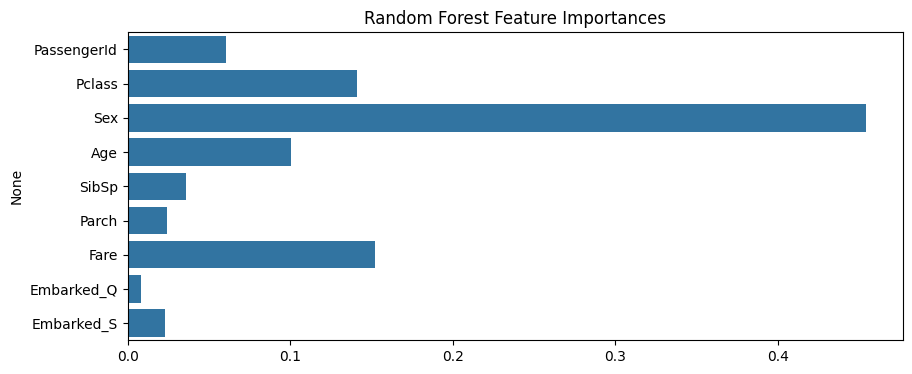

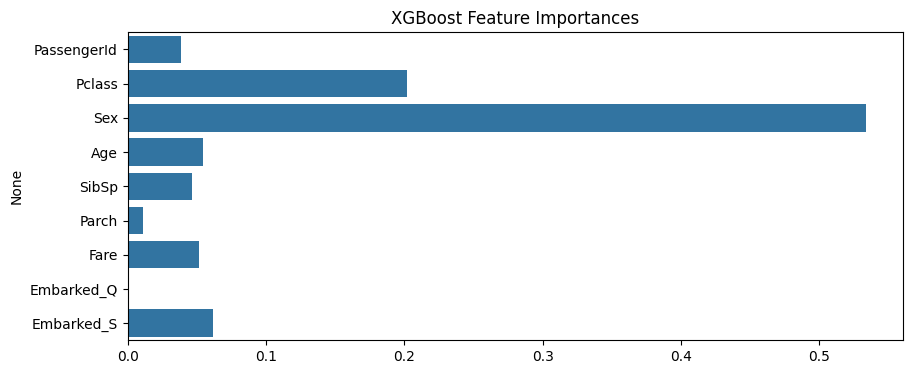

In [10]:
# =========================
# 10. BASIC INTERPRETABILITY
# =========================

# Let's look at feature importances for Random Forest and XGBoost as an example.

importances_rf = best_rf.feature_importances_
importances_xgb = best_xgb.feature_importances_

feature_names = X.columns

# Plot RF Feature Importances
plt.figure(figsize=(10,4))
sns.barplot(x=importances_rf, y=feature_names)
plt.title("Random Forest Feature Importances")
plt.show()

# Plot XGB Feature Importances
plt.figure(figsize=(10,4))
sns.barplot(x=importances_xgb, y=feature_names)
plt.title("XGBoost Feature Importances")
plt.show()